In [12]:
#install pandas
#install pandas
import math
import numpy as np
import scipy as sp
import numpy.random as npr  
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.random as npr
import datetime
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import *
import seaborn as sns
import os
from multiprocessing import Process
from multiprocessing import current_process
#seaborn.set_style("ticks")
from scipy import integrate

In [13]:
# SVCJ parameters
mu      = 0.042
r       = mu
mu_y    = -0.0492
sigma_y = 2.061
l       = 0.0515
alpha   = 0.0102
beta    = -0.188
rho     = 0.275
sigma_v = 0.007
rho_j   = -0.210
mu_v    = 0.709
v0      = 0.19**2 
kappa   = 1-beta
theta   = alpha / kappa

In [14]:
npr.seed(12345)
dt      = 1/360.0 # dt
m       = int(360.0 * (1/dt)/360.0) # time horizon in days
n       = 1000000

#for trials
#dt = 1/10
#n= 1000
#m = int(10*(1/dt)/10)

In [15]:
T      = m * dt
t      = np.arange(0,T+dt, dt)

In [16]:
w      = npr.standard_normal([n,m])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([n,m])
z_v    = npr.exponential(mu_v, [n,m])
z_y    = npr.standard_normal([n,m]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[n,m])
s      = np.zeros([n,m+1])
v      = np.zeros([n,m+1])

In [17]:
s0     = 6500
k      = 5600
s[:,0] = s0 # initial CRIX level, p. 20
v[:,0] = v0

In [18]:
for i in range(1,m+1):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    s[:,i] = s[:,i-1] * (1 + (r - l * (mu_y + rho_j * mu_v)) * dt + sp.sqrt(v[:,i-1] * dt) * w[:,i-1]) + z_v[:,i-1] * dj[:,i-1]

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


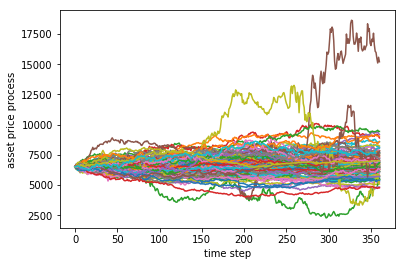

In [19]:
plt.plot(np.transpose(s[:100]));
plt.xlabel('time step')
plt.ylabel('asset price process')
plt.savefig('assetpath',transparent=T)

C:\ProgramData\Anaconda\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


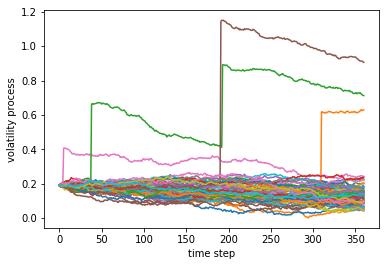

In [20]:
plt.plot(np.transpose(sp.sqrt(v[:70])));
plt.xlabel('time step')
plt.ylabel('volatility process')
plt.savefig('exactassetpath',transparent=T)

In [21]:
# Option pricing 
cp    = np.exp(-mu * m * dt) * np.maximum(s[:,-1]-k,0).mean()
cp


1261.9166993956092

In [22]:
def call_and_vol(K, T): # T maturity in years
    m = int(np.round(T / dt))
    cp = np.exp(-r * m * dt) * np.maximum(s[:,-1]-K,0).mean()
    iv = sp.optimize.minimize(solve, 0.4, args=(cp, K,T)).x[0]
    return [cp, iv]





In [23]:
def callprice(S,K,T,sigma,r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    d2 = (sp.log(S/K) + (r - 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S*scs.norm.cdf(d1) - sp.exp(-r *T) * K * scs.norm.cdf(d2)


In [24]:
#Implied volatility

def solve(sigma, cp, k, T):
    return (callprice(s0, k, T, sigma, r) - cp)**2

result     = sp.optimize.minimize(solve, 0.2, args=(cp, k, T))
impliedvol = result.x[0]
impliedvol

0.2161232866592463

In [25]:
#greeks

def deltafunc(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.cdf(d1) 

def gamma(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.pdf(d1) / (S * sigma * sp.sqrt(T))

def vega(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return S * sp.sqrt(T) * scs.norm.pdf(d1)

In [26]:
#Hedge 

bscall  = np.zeros([n,m+1])
deltabs = np.zeros([n,m+1])
ttm     = np.arange(1, m+1, 1)/m


In [27]:
# Hedging 

bscall[:,0]     = callprice(s0, k, T, impliedvol, mu)
deltabs[:,0]    = deltafunc(s0, k, T, impliedvol, mu)

In [28]:
for i in range(1,m+1):
    bscall[:,i]  = callprice(s[:,i], k, T-ttm[i-1], impliedvol, mu)
    deltabs[:,i] = deltafunc(s[:,i], k, T-ttm[i-1], impliedvol, mu)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [29]:
#code from https://www.maths.ox.ac.uk/system/files/attachments/M5_Delta%20Hedging%20using%20Merton%27s%20Jump%20Diffusion.pdf
#correct results for "known values"
st               = s[:,0]
amount           = cp
delta            = deltabs[:,0]
Pnl              = amount - deltabs[:,0]*st
interest         = np.exp(r* dt )

for i in range(1,m+1):
    t            = T-ttm[i-1]
    Pnl          = interest *Pnl
    newdelta     = deltafunc(s[:,i], k, t, impliedvol, mu)
    Pnl          = Pnl - (newdelta-delta)*s[:,i]
    delta        = newdelta

Pnl              = Pnl* interest
ST               = s[:,-1]
PayoffCheck      = [k if sT >k  else 0 for sT in ST ]

PnL_final        = [ Pnl[i]+ PayoffCheck[i] for i in range(len(Pnl))]
delta_final      = [deltabs[i,-1] -1 if PayoffCheck[i] == k else deltabs[i,-1] for i in range(len(deltabs[:,-1]))]

PnL_final        = PnL_final + delta_final * ST
PnL_final        = PnL_final/cp


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [30]:
#Lilis code from scratch
interest           = np.exp(r*dt)
balance            = cp - deltabs[:,0]*s[:,0]

for i in range(1,m+1):
    timetomaturity = T - ttm[i-1]
    buy            = deltabs[:,i] - deltabs[:,i-1]
    cost           = buy*s[:,i]
    balance        = interest*balance - cost

St                 = s[:,-1]
liabilities        = np.array([st-k if st > k else 0 for st in St])

balance            = interest*balance + (deltabs[:,-1])*s[:,-1] - np.array(liabilities)
finalbank          = list(balance)

finalbank          = [x/cp for x in finalbank]


In [31]:
#Correctness check "internet" code vs. Lili Matic code

#Comparison of floating points
eps = 1e-16
#list(abs(PnL_final-finalbank)<eps)


C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


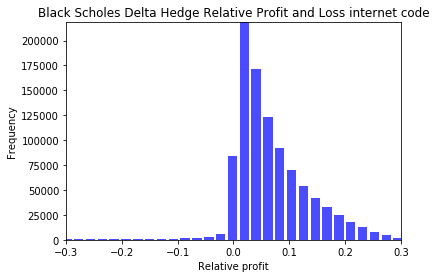

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


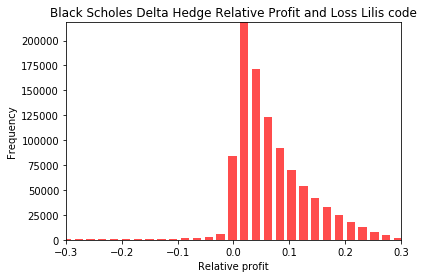

In [32]:
c, bins, patches = plt.hist(PnL_final, bins=400, color='b',alpha=0.7, rwidth=0.8)

plt.xlabel('Relative profit')
plt.ylabel('Frequency')
plt.title('Black Scholes Delta Hedge Relative Profit and Loss internet code')

maxfreq = c.max()
plt.ylim(ymax = np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -0.3, xmax = 0.3)
plt.savefig('PnLBSDeltaHedge1MioInternet',transparent=T)
plt.show()

c, bins, patches = plt.hist(x=finalbank, bins=400, color='r',alpha=0.7, rwidth=0.7)
plt.xlabel('Relative profit')
plt.ylabel('Frequency')
plt.title('Black Scholes Delta Hedge Relative Profit and Loss Lilis code')
maxfreq = c.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = -0.3, xmax=0.3)
plt.savefig('PnLBSDeltaHedge1MioLili',transparent=T)
plt.show()
